(c) 2016 - present. Enplus Advisors, Inc.

# Programming with Data<br>Foundations of Python and Pandas

# Lesson 3: Split, Apply, Combine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:,.2f}'.format)

def image(name, **kwargs):
    from IPython.display import Image
    return Image(filename=f'assets/{name}', retina=True, **kwargs)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
cols = ['year', 'month', 'day', 'hour', 'air_temp', 'dew_point',
        'pressure', 'wind_dir', 'wind_speed', 'sky_code',
        'precip1', 'precip6']
dtypes = {
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'hour': 'int8',
    'air_temp': 'Int32',
    'dew_point': 'Int32',
    'pressure': 'float64',
    'wind_dir': 'Int32',
    'wind_speed': 'float64',
    'sky_code': 'Int32',
    'precip1': 'Int32',
    'precip6': 'Int32'
}

usecols = ['year', 'month', 'day', 'hour', 'air_temp', 
           'dew_point', 'wind_speed']

dat = (pd.read_fwf(
    'data/726505-04845-2009', header=None, names=cols,
    dtype=dtypes, na_values='-9999', usecols=usecols)
    .query("month <= 6")
    .assign(
        air_temp=lambda df: df.air_temp / 10., # Celsius * 10
        dew_point=lambda df: df.dew_point / 10. # Celsius * 10
        # wind_speed=lambda df: df.wind_speed / 10. # meters/sec * 10
))

# dat[usecols].to_parquet('data/weather-6m.parq')


In [3]:
dat.year.unique()

array([2009], dtype=int16)

In [4]:
dat.dtypes

year            int16
month            int8
day              int8
hour             int8
air_temp      float64
dew_point     float64
wind_speed    float64
dtype: object

# Weather Data from NOAA

Hourly data for a single weather station in 2009.

In [5]:
dat.head()

,year,month,day,hour,air_temp,dew_point,wind_speed
0,2009,1,1,1,-13.30,-16.70,15.00
1,2009,1,1,2,-13.30,-16.10,26.00
2,2009,1,1,3,-12.20,-15.60,0.00
3,2009,1,1,4,-11.70,-15.00,0.00
4,2009,1,1,5,-11.10,-15.00,15.00


## Split, Apply, Combine

Hadley Wickham  
**The split-apply-combine strategy for data analysis.**  
_Journal of Statistical Software_, vol. 40, no. 1, pp. 1–29, 2011

Preprint: http://vita.had.co.nz/papers/plyr.pdf

## Visualize Split, Apply, Combine

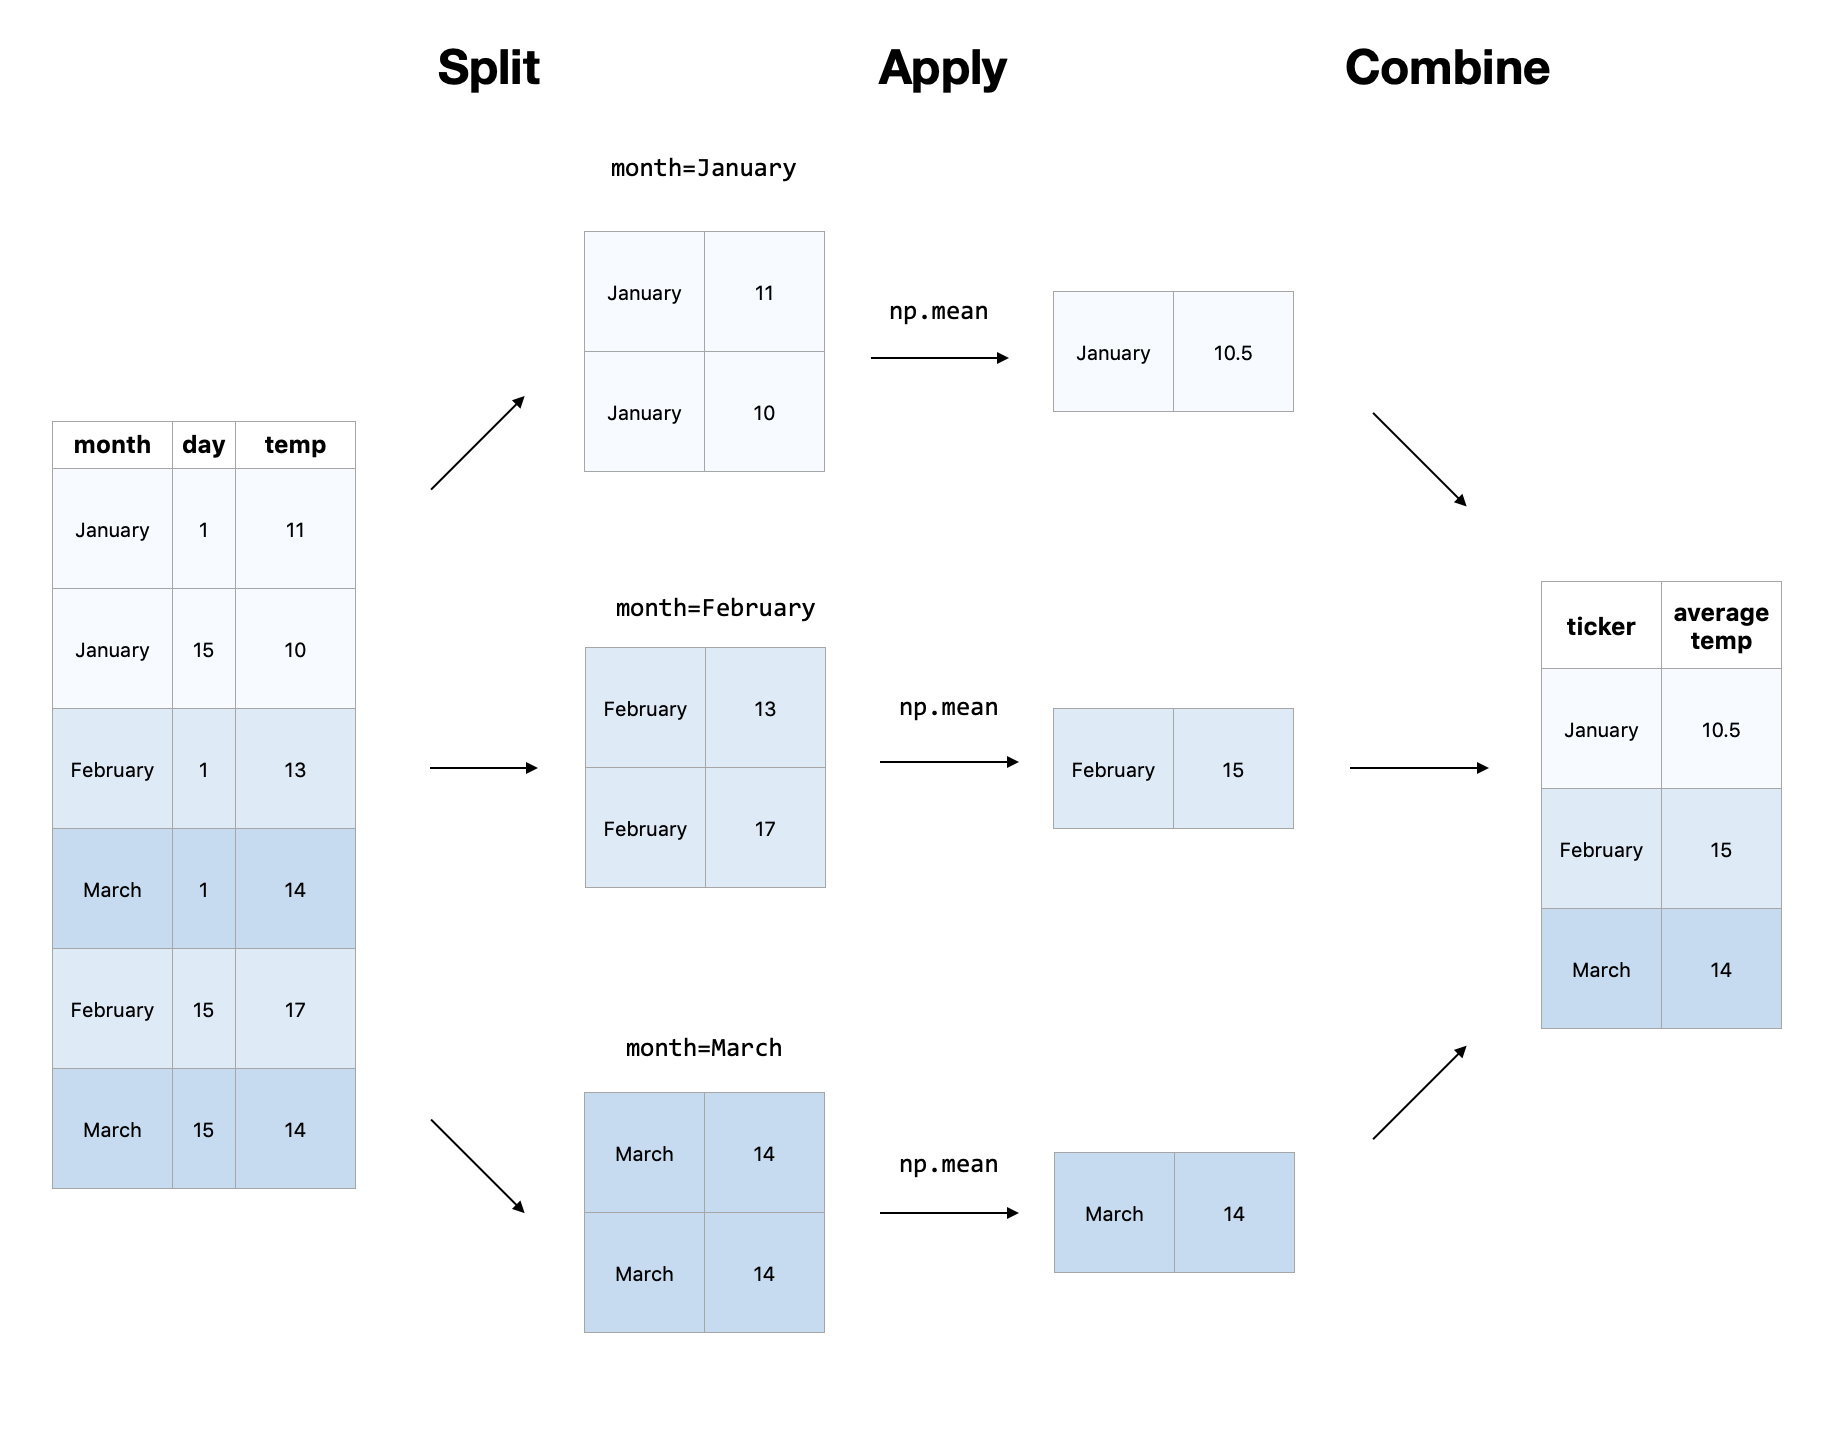

In [6]:
image('split-apply-combine.png')

## As implemented by `pandas`

* Split only
* Split-reduce/aggregate-combine
* Split-apply-combine

## Split-Only

* Iteration over the split `DataFrame`
* You are responsible for applying functions and combining data

In [7]:
grp = dat.groupby('month')

In [8]:
for month, month_df in grp:
    print(f'Month: {month}')
    break # stop the iteration

Month: 1


In [9]:
month_df.head()

,year,month,day,hour,air_temp,dew_point,wind_speed
0,2009,1,1,1,-13.30,-16.70,15.00
1,2009,1,1,2,-13.30,-16.10,26.00
2,2009,1,1,3,-12.20,-15.60,0.00
3,2009,1,1,4,-11.70,-15.00,0.00
4,2009,1,1,5,-11.10,-15.00,15.00


TODO: Show how to access the group names w/ grp.groups.keys()

TODO: Show how to get a group with grp.get_group('sector')

## Split-Reduce-Combine

Default applies to all numeric columns.

In [10]:
grp.mean()

,year,day,hour,air_temp,dew_point,wind_speed
month,,,,,,
1,2009,16.02,11.52,-10.01,-14.11,42.85
2,2009,14.50,11.50,-2.95,-7.25,47.96
3,2009,16.00,11.50,2.10,-3.42,44.69
4,2009,15.50,11.50,7.03,0.27,49.48
5,2009,16.00,11.50,13.98,6.24,42.60
6,2009,15.49,11.51,18.06,12.25,32.73


### Single column `reduce`

Reduce over one column and return a `Series` or `DataFrame`

In [11]:
# Returns a Series
grp['air_temp'].mean()

month
1   -10.01
2    -2.95
3     2.10
4     7.03
5    13.98
6    18.06
Name: air_temp, dtype: float64

In [12]:
# Returns a DataFrame
grp[['air_temp']].mean().T

month,1,2,3,4,5,6
air_temp,-10.01,-2.95,2.10,7.03,13.98,18.06


### One function, multiple columns

Apply the same function to multiple *selected* columns.

In [13]:
grp[['air_temp', 'dew_point']].mean()

,air_temp,dew_point
month,,
1,-10.01,-14.11
2,-2.95,-7.25
3,2.10,-3.42
4,7.03,0.27
5,13.98,6.24
6,18.06,12.25


### Multiple functions, one or more columns

Apply different functions to a single column.

Use `agg` method (short for `aggregate`)

Apply different functions to a single column. Result columns have the same
names as the functions, e.g. `mean`, `sum`, `std`.

In [14]:
grp['air_temp'].agg([np.mean, np.sum, 'std'])

,mean,sum,std
month,,,
1,-10.01,"-7,125.40",6.16
2,-2.95,"-1,900.70",6.78
3,2.10,"1,498.70",6.70
4,7.03,"4,855.30",5.96
5,13.98,"9,965.90",5.11
6,18.06,"12,424.80",6.00


### Multiple functions, multiple columns

Again, use the `agg` method. This parameterization gives the result `DataFrame` custom names.

In [15]:
grp.agg(
    mean_air_temp=('air_temp', lambda x: x.mean()),
    mean_dew_point=('dew_point', 'mean'),
)

,mean_air_temp,mean_dew_point
month,,
1,-10.01,-14.11
2,-2.95,-7.25
3,2.10,-3.42
4,7.03,0.27
5,13.98,6.24
6,18.06,12.25


#### Pandas < 0.25

In [16]:
grp.agg({
    'air_temp': lambda x: x.mean(),
    'dew_point': 'mean'
}).rename(columns={
    'air_temp': 'mean_air_temp',
    'dew_point': 'mean_dew_point'
})

,mean_air_temp,mean_dew_point
month,,
1,-10.01,-14.11
2,-2.95,-7.25
3,2.10,-3.42
4,7.03,0.27
5,13.98,6.24
6,18.06,12.25


## Grouping by Multiple Variables

Same idea as before, except our results now have a MultiIndex.

In [17]:
grp2 = dat.groupby(['month', 'hour'])
grp2[['air_temp']].mean()

air_temp
month hour          
1     0        -9.40
      1        -9.96
      2       -10.42
      3       -10.70
      4       -11.18
...              ...
6     19       22.25
      20       21.97
      21       21.73
      22       21.21
      23       20.87

[144 rows x 1 columns]

## Split-Apply-Combine

Reduce/aggregate (`agg`) assumes we go from many observations to 1 result value

To return multiple rows and/or columns per group, `agg` doesn't work

Need a new method, `apply`

### Apply/Reduce returning one row, > 1 columns

In [18]:
grp3 = dat.groupby('month')
grp3.apply(lambda df: df.air_temp.quantile([0.25, 0.5]))

air_temp,0.25,0.50
month,,
1,-13.30,-10.00
2,-7.20,-2.20
3,-1.70,2.20
4,2.80,5.60
5,10.60,13.90
6,13.75,17.80


### Apply/Reduce returning > 1 rows, > 1 columns

In [19]:
grp3.apply(lambda df: df.iloc[:2, ]).head(6)

year  month  day  hour  air_temp  dew_point  wind_speed
month                                                              
1     0     2009      1    1     1    -13.30     -16.70       15.00
      1     2009      1    1     2    -13.30     -16.10       26.00
2     743   2009      2    1     0      2.80      -1.70       82.00
      744   2009      2    1     1      2.80      -1.70       82.00
3     1415  2009      3    1     0     -7.20     -10.60       21.00
      1416  2009      3    1     1     -7.20     -10.00       15.00

TODO: Add Filter, Transform



SHOW: Combining index and group